In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from dataset import exeGraph

from dataset import OPS_LENGTH

C:\Users\tanas\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = exeGraph()

print(f"Amount of items: {len(dataset)}")

bn = 0
rs = 0

for d in dataset:
    if d.y.item() == 1:
        rs += 1
    elif d.y.item() == 0:
        bn += 1

print(f"Amount of ransomware: {rs}")
print(f"Amount of benign: {bn}")

print(dataset[0])

data_len = len(dataset)
train_amo = round(data_len * 0.8)

train_loader = DataLoader(dataset[:train_amo], batch_size=64, shuffle=True)
test_loader = DataLoader(dataset[train_amo:], batch_size=64, shuffle=False)

Amount of items: 245
Amount of ransomware: 202
Amount of benign: 43
Data(x=[5, 5], edge_index=[2, 4], y=[1])


In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(OPS_LENGTH, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

100%|██████████| 16/16 [00:35<00:00,  2.21s/it]


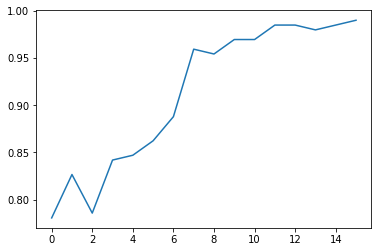

min loss: 0.7806
Epoch: 015, Test Acc: 0.9796


In [15]:
from IPython.display import Javascript
from tqdm import tqdm
import matplotlib.pyplot as plt

EPOCH = 32

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  
        out = model(data.x, data.edge_index, data.batch)  
        loss = criterion(out, data.y)
        loss.backward()  
        optimizer.step()  
        optimizer.zero_grad()  

def test(loader):
    model.eval()

    correct = 0
    for data in loader:  
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  
        correct += int((pred == data.y).sum())  
    return correct / len(loader.dataset)  

acc = []
for e in tqdm(range(EPOCH)):
    train()
    train_acc = test(train_loader)
    acc.append(train_acc)

plt.plot(acc)
plt.show()

print(f"Max accuracy: {max(acc):.4f}")
test_acc = test(test_loader)
print(f'Epoch: {e:03d}, Test Acc: {test_acc:.4f}')